# This notebook is a continuation of the classification exercises notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
import acquire
import prepare

In [2]:
raw_telco_df = acquire.get_telco_data()
raw_telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [3]:
raw_telco_df.shape

(7043, 24)

In [4]:
raw_telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
raw_telco_df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


# I utilized my prep_telco and split_telco_data functions from prepare.py to get the data ready

### Remember how we call functions from file please

In [6]:
# take note of how we had to call the prepare.py file here
telco_prepped = prepare.prep_telco(raw_telco_df)

In [7]:
telco_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            7043 non-null   object 
 1   gender                                 7043 non-null   object 
 2   senior_citizen                         7043 non-null   int64  
 3   partner                                7043 non-null   object 
 4   dependents                             7043 non-null   object 
 5   tenure                                 7043 non-null   int64  
 6   phone_service                          7043 non-null   object 
 7   multiple_lines                         7043 non-null   object 
 8   online_security                        7043 non-null   object 
 9   online_backup                          7043 non-null   object 
 10  device_protection                      7043 non-null   object 
 11  tech

In [8]:
#here, we reassign the three values returned from the split_data function to new variables
telco_train, telco_validate, telco_test = prepare.split_telco_data(telco_prepped)
print(f'telco_train: {telco_train.shape}')
print(f'telco_validate: {telco_validate.shape}')
print(f'telco_test: {telco_test.shape}')

telco_train: (3943, 48)
telco_validate: (1691, 48)
telco_test: (1409, 48)


# At this point, we now have our train, validate, test data sets

In [9]:
telco_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 5691 to 5107
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            1409 non-null   object 
 1   gender                                 1409 non-null   object 
 2   senior_citizen                         1409 non-null   int64  
 3   partner                                1409 non-null   object 
 4   dependents                             1409 non-null   object 
 5   tenure                                 1409 non-null   int64  
 6   phone_service                          1409 non-null   object 
 7   multiple_lines                         1409 non-null   object 
 8   online_security                        1409 non-null   object 
 9   online_backup                          1409 non-null   object 
 10  device_protection                      1409 non-null   object 
 11  t

In [10]:
telco_test.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,1409.0,0.166785,0.372916,0.0,0.00,0.0,0.00,1.00
tenure,1409.0,32.327892,24.539256,0.0,9.00,27.0,56.00,72.00
monthly_charges,1409.0,65.595138,30.094806,18.4,39.15,70.8,90.35,118.35
total_charges,1409.0,2302.195742,2281.833262,0.0,415.90,1426.4,3771.50,8529.50
gender_Male,1409.0,0.530873,0.499223,0.0,0.00,1.0,1.00,1.00
partner_Yes,1409.0,0.485451,0.499966,0.0,0.00,0.0,1.00,1.00
dependents_Yes,1409.0,0.276792,0.447572,0.0,0.00,0.0,1.00,1.00
phone_service_Yes,1409.0,0.894251,0.307625,0.0,1.00,1.0,1.00,1.00
multiple_lines_No phone service,1409.0,0.105749,0.307625,0.0,0.00,0.0,0.00,1.00
multiple_lines_Yes,1409.0,0.422995,0.494210,0.0,0.00,0.0,1.00,1.00


# Univariate analysis:

In [11]:
# this cell is isolating the number format columns for analysis below

num_cols = telco_test.columns[[telco_test[col].dtype in ('int64', 'float64') for col in telco_test.columns]]
num_cols

Index(['senior_citizen', 'tenure', 'monthly_charges', 'total_charges'], dtype='object')

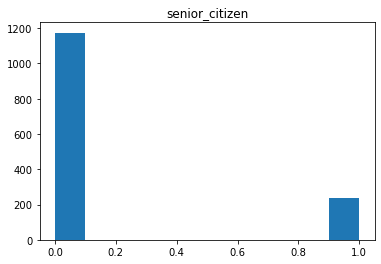

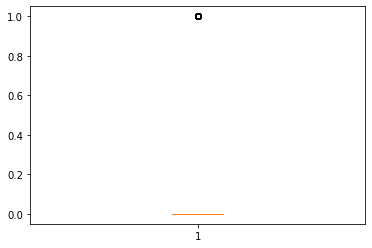

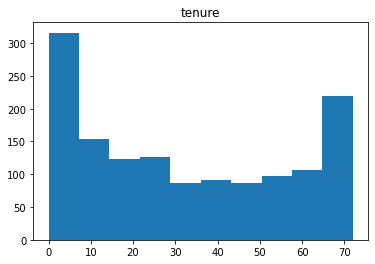

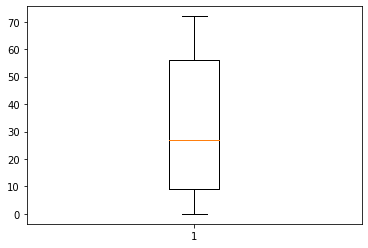

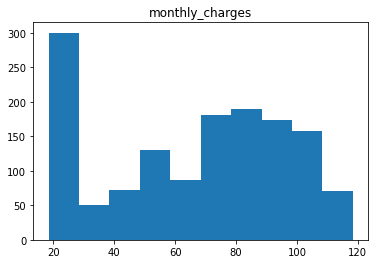

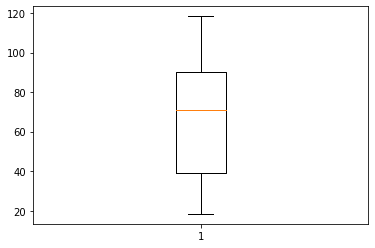

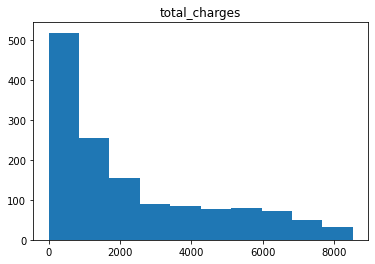

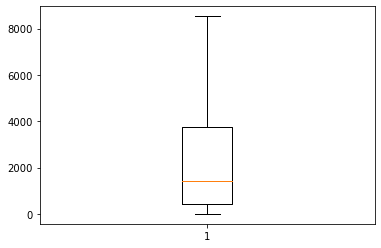

In [12]:
# this cell is giving me a histogram and boxplot for all numerical data.  

for col in num_cols:
    plt.hist(telco_test[col])
    plt.title(col)
    plt.show()
    plt.boxplot(telco_test[col])
    plt.show()

In [13]:
# this cell is isolating the columns with an object ('O') type for analysis

obj_cols = telco_test.columns[[telco_test[col].dtype == 'O' for col in telco_test.columns]]
obj_cols

Index(['customer_id', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [14]:
# and here, we get an idea of what each object feature contains

for col in obj_cols:
    print(telco_test[col].value_counts())
    print(telco_test[col].value_counts(normalize = True, dropna=False))
    print('------------------------')

5985-TBABQ    1
8200-LGKSR    1
2809-ZMYOQ    1
0455-ENTCR    1
6959-UWKHF    1
             ..
4718-DHSMV    1
3223-WZWJM    1
5696-CEIQJ    1
1730-VFMWO    1
7252-NTGSS    1
Name: customer_id, Length: 1409, dtype: int64
5985-TBABQ    0.00071
8200-LGKSR    0.00071
2809-ZMYOQ    0.00071
0455-ENTCR    0.00071
6959-UWKHF    0.00071
               ...   
4718-DHSMV    0.00071
3223-WZWJM    0.00071
5696-CEIQJ    0.00071
1730-VFMWO    0.00071
7252-NTGSS    0.00071
Name: customer_id, Length: 1409, dtype: float64
------------------------
Male      748
Female    661
Name: gender, dtype: int64
Male      0.530873
Female    0.469127
Name: gender, dtype: float64
------------------------
No     725
Yes    684
Name: partner, dtype: int64
No     0.514549
Yes    0.485451
Name: partner, dtype: float64
------------------------
No     1019
Yes     390
Name: dependents, dtype: int64
No     0.723208
Yes    0.276792
Name: dependents, dtype: float64
------------------------
Yes    1260
No      149
Name: phon

In [15]:
telco_test.monthly_charges.value_counts(bins=5, sort=False)

(18.299, 38.39]    350
(38.39, 58.38]     202
(58.38, 78.37]     267
(78.37, 98.36]     362
(98.36, 118.35]    228
Name: monthly_charges, dtype: int64